In [1]:
import os
os.chdir('..')

In [2]:
from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Dataset generator
n = 10
m = 5
hop = 0.25
input_dim   = 30 * n
pred_dim    = 30 * m
shift       = pred_dim
batch_size  = 64
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll']
                )

In [4]:
%load_ext autoreload
%autoreload 2

(16, 1200, 1)


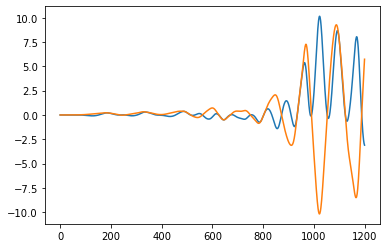

In [30]:
for x, y in Data.Train.take(2):
    print(x.shape)
    t1 = np.array(range(len(x[0,:,0])))*0.25
    plt.plot(x[0,:,0]*np.sin(2*np.pi*t1/37.9))
    plt.plot(x[0,:,0])
    # plt.show()
    break
    

In [5]:
# Loss functions
# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()

# Metrics
# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [6]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

In [7]:
print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: [1200, 1]
Output dim: [600, 1]


In [8]:
norm = tf.keras.layers.Normalization(input_shape=INPUT_DIM, axis=-1)
x_ds = Data.Train.map(lambda x, y: x)
norm.adapt(x_ds)

In [17]:

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_DIM),
    norm,
    tf.keras.layers.LSTM(units=1024, return_sequences=True),
    tf.keras.layers.LSTM(units=OUTPUT_DIM[0], return_sequences=False),
#     tf.keras.layers.Dense(OUTPUT_DIM[0])
])

In [18]:
model.compile(optimizer='adam', loss=MSE_loss, metrics=[MAPE, MAE])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1200, 1)          3         
 n)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1200, 1024)        4202496   
                                                                 
 lstm_3 (LSTM)               (None, 600)               3900000   
                                                                 
Total params: 8,102,499
Trainable params: 8,102,496
Non-trainable params: 3
_________________________________________________________________


In [11]:
for x, y in Data.Train.take(1):
    out = model(x)
    print(out.shape)

(64, 600)


In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

In [20]:
model.fit(Data.Train, epochs=100, validation_data=Data.Val, callbacks=[early_stopping])

Epoch 1/100
108/108 [==============================] - 3884s 36s/step - loss: 15.4804 - mean_absolute_percentage_error: 246.8422 - mean_absolute_error: 1.9549 - val_loss: 8.9525 - val_mean_absolute_percentage_error: 229.9588 - val_mean_absolute_error: 1.5329
Epoch 2/100
108/108 [==============================] - 3789s 35s/step - loss: 15.2746 - mean_absolute_percentage_error: 160.9278 - mean_absolute_error: 1.9845 - val_loss: 9.0017 - val_mean_absolute_percentage_error: 159.2713 - val_mean_absolute_error: 1.5510
Epoch 3/100
108/108 [==============================] - 3792s 35s/step - loss: 15.4896 - mean_absolute_percentage_error: 132.0425 - mean_absolute_error: 1.9843 - val_loss: 8.9275 - val_mean_absolute_percentage_error: 193.3421 - val_mean_absolute_error: 1.5354
Epoch 4/100
108/108 [==============================] - 3792s 35s/step - loss: 15.3128 - mean_absolute_percentage_error: 194.3837 - mean_absolute_error: 2.0044 - val_loss: 9.0439 - val_mean_absolute_percentage_error: 176.116

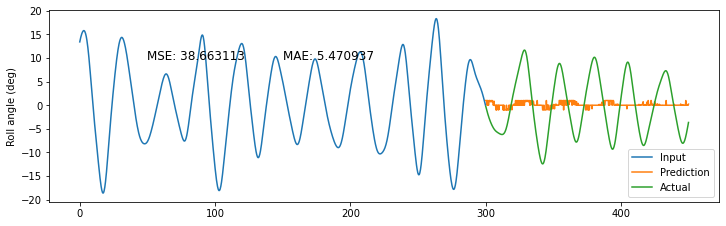

In [21]:
Data.plot_example(50, model)

In [22]:
model.save('models\oneshot_rnn_model5_nopitch')

INFO:tensorflow:Assets written to: models\oneshot_rnn_model5_nopitch\assets


INFO:tensorflow:Assets written to: models\oneshot_rnn_model5_nopitch\assets


In [34]:
model = tf.keras.models.load_model('models\oneshot_rnn_model2')

In [15]:
MAX_EPOCHS = 20

def lr_optimizer(model, window, patience=2):

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-7 * 10**(epoch / 4))

  model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(),
                metrics=[MAPE, MAE])

  history = model.fit(window.Train, epochs=MAX_EPOCHS,
                      validation_data=window.Val,
                      callbacks=[lr_scheduler])
  return history

In [16]:
history = lr_optimizer(oneshot_rnn_model, data)

Epoch 1/20
2738/2738 [==============================] - 105s 38ms/step - loss: 15.2822 - mean_absolute_percentage_error: 148.3496 - mean_absolute_error: 1.9759 - val_loss: 8.8733 - val_mean_absolute_percentage_error: 126.5278 - val_mean_absolute_error: 1.5410 - lr: 1.0000e-07
Epoch 2/20
2170/2738 [======================>.......] - ETA: 20s - loss: 19.1159 - mean_absolute_percentage_error: 156.3536 - mean_absolute_error: 2.3853

(1e-05, 0.001, 0.0, 20.0)

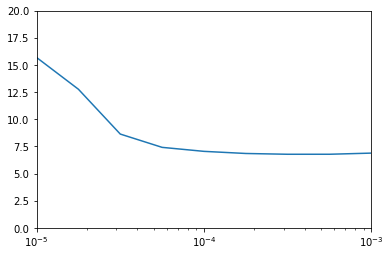

In [ ]:
lrs = 1e-5 * (10 ** (np.arange(MAX_EPOCHS) / 4))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-5, 1e-3, 0, 20])

In [ ]:
oneshot_rnn_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, input_shape=[INPUT_DIM, 1]),
    tf.keras.layers.Dense(OUTPUT_DIM)
])

In [ ]:
MAX_EPOCHS_TRAINING = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-5 * 10**(epoch / 4))

  model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(learning_rate=1e-6),
                metrics=[MAPE, MAE])

  history = model.fit(window.Train, epochs=MAX_EPOCHS_TRAINING,
                      validation_data=window.Val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history_training = compile_and_fit(oneshot_rnn_model, data)

Epoch 1/50
2738/2738 [==============================] - 11s 4ms/step - loss: 15.5703 - mean_absolute_percentage_error: 382.5428 - mean_absolute_error: 1.9267 - val_loss: 8.4941 - val_mean_absolute_percentage_error: 183.6258 - val_mean_absolute_error: 1.4975
Epoch 2/50
2738/2738 [==============================] - 11s 4ms/step - loss: 13.8828 - mean_absolute_percentage_error: 504.6201 - mean_absolute_error: 1.8486 - val_loss: 7.0495 - val_mean_absolute_percentage_error: 261.8087 - val_mean_absolute_error: 1.3449
Epoch 3/50
2738/2738 [==============================] - 11s 4ms/step - loss: 11.6106 - mean_absolute_percentage_error: 856.0525 - mean_absolute_error: 1.6606 - val_loss: 5.5768 - val_mean_absolute_percentage_error: 348.3853 - val_mean_absolute_error: 1.1778
Epoch 4/50
2738/2738 [==============================] - 12s 4ms/step - loss: 9.8274 - mean_absolute_percentage_error: 876.2321 - mean_absolute_error: 1.5115 - val_loss: 4.6665 - val_mean_absolute_percentage_error: 377.0802 - v

In [39]:
val_performance = model.evaluate(Data.Val)
test_performance = model.evaluate(Data.Test)

62/62 [==============================] - 40s 640ms/step - loss: 7.8260 - mean_absolute_percentage_error: 259.8730 - mean_absolute_error: 1.3493


In [40]:
print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

Validation MSE_loss: 5.76
Validation MAPE:     325.77
Validation MAE:      1.12
Test MSE_loss:       7.83
Test MAPE:           259.87
Test MAE:            1.35
